# Electrolyzer Data Exploratoy Data analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
    
# Set a random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.layers import Input, Conv1D, Flatten, Dense, Reshape, Conv1DTranspose
from keras.models import Model
from keras.models import clone_and_build_model
from keras.callbacks import EarlyStopping

from helper_function import *

# Preprocess data and Train Test split (Discard first 40 samples just after the fault was introduced)

In [2]:
# Import the data
data = pd.read_csv("Electrolyzer_faults.csv")
X,Y,Z = sliding_window(data, window_size=40, stride=1)
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
X_sc=sc.fit_transform(X.reshape(-1,X.shape[2])).reshape(X.shape)

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, z_train, z_test = train_test_split(X_sc, Z, test_size=0.2)

# SOTA-3: Siamese contrastive learning

In [5]:
def mask_data(X, mask_percentage=0.10):
    X_masked = np.zeros(X.shape)
    Mask = np.zeros(X.shape)
    for i,x in enumerate(X):
        binary_mask = np.random.choice([1, 0], size=x.shape, p=[1 - mask_percentage, mask_percentage])
        x_masked = x * binary_mask
        X_masked[i] = x_masked
        Mask[i] = binary_mask
    return X_masked, Mask

In [6]:
def Crete_siamese_pairs(x_train):
    x_1, _ = mask_data(x_train)
    x_2,_ = mask_data(x_train)
    same_pairs = np.array([x_1,x_2])
    same_pair_labels = np.ones(len(x_train))

    #different pair labels
    original_idx = np.arange(0,len(x_1))
    permuted_idx = original_idx.copy()

    while any(permuted_idx [i] == original_idx[i] for i in range(len(original_idx))):
        np.random.shuffle(permuted_idx)

    different_pairs = np.array([x_1,x_2[permuted_idx]])
    different_pair_labels = np.zeros(len(x_train))

    concatenated_X = np.concatenate((same_pairs, different_pairs), axis=1)
    concatenated_labels = np.concatenate((same_pair_labels, different_pair_labels), axis=0)
    return concatenated_X, concatenated_labels


In [7]:
import keras.backend as K
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [8]:
def build_siamese_model(input_shape):
    input_layer = Input(shape=(input_shape[1],input_shape[2]))
    # Define LSTM layers with batch normalization in between
    cnn1 = Conv1D(32,3,padding='same', activation='relu')(input_layer)
    cnn1 = Conv1D(32,3,padding='same', activation='relu')(cnn1)
    cnn1 = Flatten()(cnn1)
    # Define hidden layer with batch normalization
    embedding_layer = Dense(units=64, activation='relu')(cnn1)
    model = Model(input_layer, embedding_layer)
    return model

In [9]:
from tensorflow.keras.layers import Lambda

imgA = Input(shape=(x_train.shape[1],x_train.shape[2]))
imgB = Input(shape=(x_train.shape[1],x_train.shape[2]))
featureExtractor = build_siamese_model(x_train.shape)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

In [10]:
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
Siamese_model = Model(inputs=[imgA, imgB], outputs=outputs)
Siamese_model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])

In [11]:
Train_pairs,Train_labels = Crete_siamese_pairs(x_train)
Test_pairs,Test_labels = Crete_siamese_pairs(x_test)

# Pretraining using hybrid method

In [18]:
from keras.callbacks import EarlyStopping
#Pretraining using pseudo labels
psuedo_label_model = DeepLearningModel(x_train, z_train,last_layer_activn='sigmoid',loss_fn='binary_crossentropy')
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = psuedo_label_model.fit(x_train, z_train, epochs=200, batch_size=128, validation_data=(x_test, z_test), callbacks=[early_stop])

Epoch 1/200
29/29 [==============================] - 1s 18ms/step - loss: 0.4478 - binary_accuracy: 0.8714 - val_loss: 0.2562 - val_binary_accuracy: 0.9332
Epoch 2/200
29/29 [==============================] - 0s 10ms/step - loss: 0.1883 - binary_accuracy: 0.9428 - val_loss: 0.1303 - val_binary_accuracy: 0.9528
Epoch 3/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1233 - binary_accuracy: 0.9544 - val_loss: 0.1076 - val_binary_accuracy: 0.9586
Epoch 4/200
29/29 [==============================] - 0s 5ms/step - loss: 0.1033 - binary_accuracy: 0.9602 - val_loss: 0.0942 - val_binary_accuracy: 0.9622
Epoch 5/200
29/29 [==============================] - 0s 5ms/step - loss: 0.0907 - binary_accuracy: 0.9655 - val_loss: 0.0848 - val_binary_accuracy: 0.9682
Epoch 6/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0830 - binary_accuracy: 0.9698 - val_loss: 0.0799 - val_binary_accuracy: 0.9691
Epoch 7/200
29/29 [==============================] - 0s 6ms/step - l

# Pretraining using Siamese Network

Epoch 1/200
27/27 [==============================] - 2s 37ms/step - loss: 0.5521 - accuracy: 0.5000 - val_loss: 0.5057 - val_accuracy: 0.5000
Epoch 2/200
27/27 [==============================] - 1s 26ms/step - loss: 0.4812 - accuracy: 0.5000 - val_loss: 0.4721 - val_accuracy: 0.5000
Epoch 3/200
27/27 [==============================] - 1s 29ms/step - loss: 0.4546 - accuracy: 0.5017 - val_loss: 0.4521 - val_accuracy: 0.5041
Epoch 4/200
27/27 [==============================] - 1s 21ms/step - loss: 0.4361 - accuracy: 0.5182 - val_loss: 0.4366 - val_accuracy: 0.5244
Epoch 5/200
27/27 [==============================] - 1s 24ms/step - loss: 0.4215 - accuracy: 0.5597 - val_loss: 0.4239 - val_accuracy: 0.5650
Epoch 6/200
27/27 [==============================] - 1s 30ms/step - loss: 0.4088 - accuracy: 0.6129 - val_loss: 0.4129 - val_accuracy: 0.6092
Epoch 7/200
27/27 [==============================] - 1s 25ms/step - loss: 0.3979 - accuracy: 0.6709 - val_loss: 0.4036 - val_accuracy: 0.6638
Epoch 

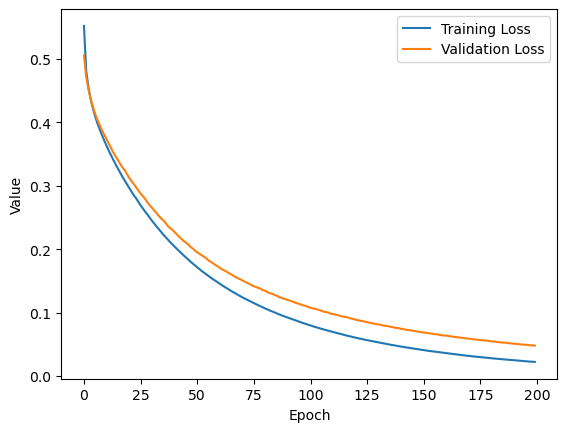

In [12]:
from keras.callbacks import EarlyStopping
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = Siamese_model.fit([Train_pairs[0], Train_pairs[1]], Train_labels[:],
	validation_data=([Test_pairs[0], Test_pairs[1]], Test_labels[:]),batch_size=256, epochs=200, callbacks=[early_stop])


# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

# Fine Tune the AE model

In [13]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
Y_ohe = ohe.fit_transform(Y.reshape(-1,1))

In [14]:
def FineTunedModel(nn_model,x_train,y_train,X_sc,Y_ohe,method='hybrid'):
    nn_model.compile()

    from keras.layers import BatchNormalization
    from keras.models import clone_and_build_model

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



    if method == 'hybrid':
        model_copy= clone_and_build_model(nn_model)
        model_copy.set_weights(weights=nn_model.get_weights())
        intermediate_model = Model(inputs=model_copy.input,outputs=model_copy.layers[-2].output)
    else:
        model_copy= clone_and_build_model(nn_model)
        model_copy.set_weights(weights=nn_model.get_weights())
        intermediate_model = Model(inputs=model_copy.input,outputs=model_copy.layers[-1].output)

    for l in intermediate_model.layers:
        l.trainable=False

    fine_tuned_layers = Dense(units=64,activation='relu')(intermediate_model.output)
    output_layer = Dense(units=Y_ohe.shape[1],activation='softmax')(fine_tuned_layers)

    # Define the model
    fine_tuned_model = Model(inputs=intermediate_model.input, outputs=output_layer)

    # Compile the model with binary cross-entropy loss function and Adam optimizer
    fine_tuned_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #categorical_hinge

    #train the model with freezed layer
    fine_tuned_model.fit(x_train, y_train, epochs=500, batch_size=int(len(x_train) * 0.2), validation_data=(X_sc[::50], Y_ohe[::50]), callbacks=[early_stop], verbose=0)

    for l in fine_tuned_model.layers:
        l.trainable=True

    # Create a custom Adam optimizer with a small learning rate
    custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    # Compiling again is necessary to update the trainable parameter before training
    fine_tuned_model.compile(loss='categorical_crossentropy', optimizer=custom_optimizer, metrics=['accuracy']) #categorical_hinge

    #train the model with freezed layer
    fine_tuned_model.fit(x_train, y_train, epochs=50, batch_size=int(len(x_train) * 0.2), validation_data=(X_sc[::50], Y_ohe[::50]), callbacks=[early_stop], verbose=0)

    return fine_tuned_model

In [15]:
from sklearn.metrics import f1_score, accuracy_score

set_of_samples = [4, 8, 16, 32, 64, 90]
num_repetitions = 10

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("FineTuned Model Training")
F1_score_finetuned = np.zeros((num_repetitions, len(set_of_samples)))

for repetition in range(num_repetitions):
    print(f"**************** repetation - {repetition} ****************")
    for i, samples in enumerate(set_of_samples):
        print(f'Repetition {repetition + 1}: Training samples per class = {samples}')
 
        x_val, y_val, _ = Resample(X_sc, Y, Z, samples)
        y_val = ohe.transform(y_val.reshape(-1, 1))

        fine_tuned_model = FineTunedModel(featureExtractor,x_val,y_val,X_sc,Y_ohe,method='sota3')
        
        x_train,y_train,z_train = Resample(X,Y,Z,50)
        x_train = sc.transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
        
        y_pred = fine_tuned_model.predict(x_train)
        y_pred = ohe.inverse_transform(y_pred)
        f1 = f1_score(y_train, y_pred, average='macro')
        print(f'F1 score on whole dataset = {f1}')
        F1_score_finetuned[repetition, i] = f1

print("F1 Scores Matrix:")
print(F1_score_finetuned)

FineTuned Model Training
**************** repetation - 0 ****************
Repetition 1: Training samples per class = 4
16/16 [==============================] - 0s 3ms/step
F1 score on whole dataset = 0.6814231402289784
Repetition 1: Training samples per class = 8
16/16 [==============================] - 0s 5ms/step
F1 score on whole dataset = 0.7964637241192866
Repetition 1: Training samples per class = 16
16/16 [==============================] - 0s 2ms/step
F1 score on whole dataset = 0.8074117957966246
Repetition 1: Training samples per class = 32
16/16 [==============================] - 0s 3ms/step
F1 score on whole dataset = 0.9017927792779277
Repetition 1: Training samples per class = 64
16/16 [==============================] - 0s 2ms/step
F1 score on whole dataset = 0.9235095670739234
Repetition 1: Training samples per class = 90
16/16 [==============================] - 0s 6ms/step
F1 score on whole dataset = 0.9136394148343883
**************** repetation - 1 ****************
Rep

# Save the experiment in csv file

In [16]:
mean_f1_scores_ae = np.mean(F1_score_finetuned, axis=0)
variance_f1_scores_ae= np.var(F1_score_finetuned, axis=0)

results_dict = {
    'No training samples': set_of_samples,
    'Model': ['SOA3'] * len(set_of_samples) ,
    'Mean F1 score': mean_f1_scores_ae,
    'Error': variance_f1_scores_ae
}

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(results_dict)

# Save the DataFrame to a CSV file
results_df.to_csv('SOA3_siamese.csv', index=False)

# The proposed hybrid model

In [106]:

# Create fullySupervided NEtwork
print("Propose hybrid method")
F1_score_hybrid = np.zeros((num_repetitions, len(set_of_samples)))

for repetition in range(num_repetitions):
    for i, samples in enumerate(set_of_samples):
        print(f'Repetition {repetition + 1}: Training samples per class = {samples}')
        x_val, y_val, _ = resample(X_sc, Y,Z, samples)
        y_val_ohe = ohe.transform(y_val.reshape(-1, 1))

        hybrid_model = FineTunedModel(psuedo_label_model,x_val,y_val_ohe,X_sc,Y_ohe)
        
        x_train,y_train,z_train = resample(X,Y,Z,50)
        x_train = sc.transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
        
        y_pred = hybrid_model.predict(x_train)
        y_pred = ohe.inverse_transform(y_pred)
        y_pred = Cascade_Hybrid_FDI(x_train,z_train,y_pred)
        f1 = f1_score(y_train, y_pred, average='macro')
        print(f'F1 score on whole dataset = {f1}')
        F1_score_hybrid[repetition, i] = f1

print("F1 Scores Matrix:")
print(F1_score_hybrid)

Propose hybrid method
Repetition 1: Training samples per class = 4
F1 score on whole dataset = 0.8484703238284265
Repetition 1: Training samples per class = 8
F1 score on whole dataset = 0.8826503936377816
Repetition 1: Training samples per class = 16
F1 score on whole dataset = 0.8969445305076821
Repetition 1: Training samples per class = 32
F1 score on whole dataset = 0.9023210448503297
Repetition 1: Training samples per class = 64
F1 score on whole dataset = 0.9129704393388689
Repetition 1: Training samples per class = 90
F1 score on whole dataset = 0.9084271591499291
Repetition 2: Training samples per class = 4
F1 score on whole dataset = 0.847352597620722
Repetition 2: Training samples per class = 8
F1 score on whole dataset = 0.8782420629102292
Repetition 2: Training samples per class = 16
F1 score on whole dataset = 0.9028560372402541
Repetition 2: Training samples per class = 32
F1 score on whole dataset = 0.8934516825500799
Repetition 2: Training samples per class = 64
F1 scor

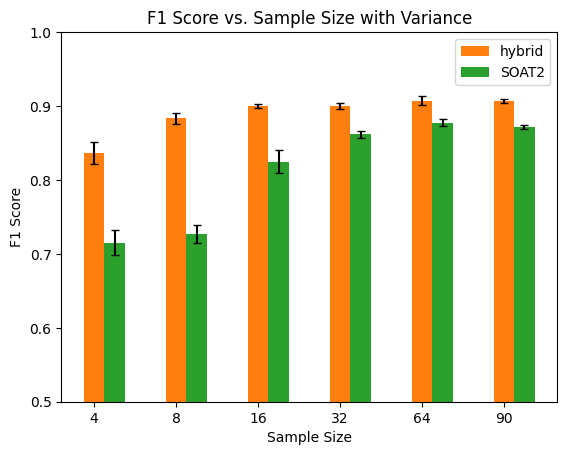

In [107]:
import numpy as np
import matplotlib.pyplot as plt

set_of_samples = [4, 8, 16, 32, 64, 90]

# Calculate the mean and variance of F1 scores for each sample size


mean_f1_scores_hybrid = np.mean(F1_score_hybrid, axis=0)
variance_f1_scores_hybrid = np.var(F1_score_hybrid, axis=0)

mean_f1_scores_ae = np.mean(F1_score_finetuned, axis=0)
variance_f1_scores_ae= np.var(F1_score_finetuned, axis=0)

# Set the width of each bar
bar_width = 0.25

# Create an array representing the x-axis positions
x = np.arange(len(set_of_samples))

# Choose colors for three classes
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create side-by-side bar plots with error bars
plt.bar(x, mean_f1_scores_hybrid, bar_width, yerr=np.sqrt(variance_f1_scores_hybrid), capsize=3, color=colors[1], label='hybrid')
plt.bar(x + bar_width, mean_f1_scores_ae, bar_width, yerr=np.sqrt(variance_f1_scores_ae), capsize=3, color=colors[2], label='SOAT2')

plt.grid(visible=False)
plt.legend()
plt.xlabel('Sample Size')
plt.ylabel('F1 Score')
plt.ylim([0.5,1])
plt.title('F1 Score vs. Sample Size with Variance')
plt.xticks(x, [str(x) for x in set_of_samples])
plt.show()
